In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [2]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"  #'Times New Roman'

In [3]:
class CFG:
    input_dir = "../input"
    output_dir = "../output"
    random_seed = 42
    exp_no = "exp000"

In [4]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,界1_1.5,2024/1/19,高岡,界面活性剤1水準振り,47.4,40,0,2,0,...,25,NaN,10,5,2.436266,1.068034,9.000,38.24,NaN,NaN
1,DP_002,界1_1.2,2024/1/19,高岡,界面活性剤1水準振り,47.7,40,0,2,0,...,25,NaN,10,5,2.436266,1.074034,9.000,40.04,NaN,NaN
2,DP_003,界1_1.0,2024/1/19,高岡,界面活性剤1水準振り,47.9,40,0,2,0,...,25,NaN,10,5,2.436266,1.078034,9.000,41.24,NaN,NaN
3,DP_004,界1_0.5,2024/1/19,高岡,界面活性剤1水準振り,48.4,40,0,2,0,...,25,NaN,10,5,2.436266,1.088034,9.000,44.24,NaN,NaN
4,DP_005,界1_1.5_樹1_4.0_ref,2024/1/30,福原,ref,47.4,40,0,2,0,...,25,NaN,10,5,2.705816,1.068034,9.060,38.24,NaN,NaN
5,DP_006,界2_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,25,NaN,10,5,2.705816,1.048034,9.060,36.74,NaN,NaN
6,DP_007,界3_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,25,NaN,10,5,2.705816,1.023034,9.060,38.99,NaN,NaN
7,DP_008,界1_1.5_樹1_6.0,2024/1/30,福原,定着樹脂１水準振り,45.4,40,0,2,0,...,25,NaN,10,5,3.133725,1.068034,10.260,36.32,NaN,NaN
8,DP_009,界1_1.5_樹1_8.0,2024/1/30,福原,定着樹脂１水準振り,43.4,40,0,2,0,...,25,NaN,10,5,3.561633,1.068034,11.460,34.40,NaN,NaN
9,DP_010,界1_1.5_樹1_10.0,2024/1/30,福原,定着樹脂１水準振り,41.4,40,0,2,0,...,25,NaN,10,5,3.989541,1.068034,12.660,32.48,NaN,NaN


In [5]:
# train_dfの列名をリストで取得
columns = train_df.columns
# train_dfの列名を表示
columns

Index(['サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考', '溶媒１', '溶媒2', '溶媒3', '添加剤1',
       '添加剤2', '界面活性剤１', '界面活性剤２', '界面活性剤３', '顔料１', '顔料２', '定着樹脂１', '定着樹脂２',
       '防腐剤', '塗布量', '乾燥方式', '乾燥温度', '乾燥時間', '擦過回数', '擦過圧力', '耐擦過性(n10',
       '画像濃度', '粘度', '表面張力', '保存後粘度', '保存後状態'],
      dtype='object')

In [6]:
# 欠損のある列を表示
train_df.isnull().sum()

サンプルID       0
サンプル名        0
サンプル作成日      0
担当者          0
備考           0
溶媒１          0
溶媒2          0
溶媒3          0
添加剤1         0
添加剤2         0
界面活性剤１       0
界面活性剤２       0
界面活性剤３       0
顔料１          0
顔料２          0
定着樹脂１        0
定着樹脂２        0
防腐剤          0
塗布量          0
乾燥方式         0
乾燥温度         0
乾燥時間        12
擦過回数         0
擦過圧力         0
耐擦過性(n10     0
画像濃度         0
粘度           0
表面張力         0
保存後粘度       24
保存後状態       24
dtype: int64

In [7]:
numeric_parameter_cols = [
    # 'サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考',
    "溶媒１",
    "溶媒2",
    "溶媒3",
    "添加剤1",
    "添加剤2",
    "界面活性剤１",
    "界面活性剤２",
    "界面活性剤３",
    "顔料１",
    "顔料２",
    "定着樹脂１",
    "定着樹脂２",
    "防腐剤",
    "塗布量",
    "乾燥方式",
    "乾燥温度",
    # '乾燥時間',
    "擦過回数",
    "擦過圧力",
    # '耐擦過性(n10','画像濃度', '粘度', '表面張力', '保存後粘度'
]

In [8]:
train_X = train_df[numeric_parameter_cols]
objective_cols = ["耐擦過性(n10"]
train_Y = train_df[objective_cols]

0it [00:00, ?it/s]

c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  w

Int64Index([0], dtype='int64')
RMSE_train: 0.6024244833644091
MAE_train: 0.40780072177921367
R2_train: 0.7438277593050442
Int64Index([1], dtype='int64')
RMSE_train: 0.6032878633492361
MAE_train: 0.4092250323339877
R2_train: 0.7430929535925936
Int64Index([2], dtype='int64')
RMSE_train: 0.603672756118651
MAE_train: 0.40987475386970657
R2_train: 0.7427650397941117
Int64Index([3], dtype='int64')
RMSE_train: 0.6042584798376167
MAE_train: 0.41067215964228154
R2_train: 0.7422656244721471

c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



Int64Index([4], dtype='int64')
RMSE_train: 0.6045687451004054
MAE_train: 0.4156669008016461
R2_train: 0.7464173129445426
Int64Index([5], dtype='int64')
RMSE_train: 0.6033208014437993
MAE_train: 0.4090663072761123
R2_train: 0.7474631172306428
Int64Index([6], dtype='int64')
RMSE_train: 0.6033208014437993
MAE_train: 0.4090663072761123
R2_train: 0.7474631172306428
Int64Index([7], dtype='int64')
RMSE_train: 0.6039389301290969
MAE_train: 0.41057163843845784
R2_train: 0.7518557588820993


c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMet

Int64Index([8], dtype='int64')
RMSE_train: 0.6022154414285549
MAE_train: 0.40578344323638627
R2_train: 0.7558378765536731
Int64Index([9], dtype='int64')
RMSE_train: 0.5987295185763812
MAE_train: 0.40056886219648413
R2_train: 0.7590449369473367
Int64Index([10], dtype='int64')
RMSE_train: 0.6021493090566543
MAE_train: 0.4088381431967453
R2_train: 0.735059962419668
Int64Index([11], dtype='int64')
RMSE_train: 0.602750248398008
MAE_train: 0.4124292592335469
R2_train: 0.7404521455908727
Int64Index([12], dtype='int64')
RMSE_train: 0.5372479331641921
MAE_train: 0.35107679238764306
R2_train: 0.7983745027931441


c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMet

Int64Index([13], dtype='int64')
RMSE_train: 0.5685231966999224
MAE_train: 0.3832008327067508
R2_train: 0.7757831130374536
Int64Index([14], dtype='int64')
RMSE_train: 0.5113645880616449
MAE_train: 0.34232942870281113
R2_train: 0.8128922986259846
Int64Index([15], dtype='int64')
RMSE_train: 0.5568961321901177
MAE_train: 0.35879409390320466
R2_train: 0.7872300736864164
Int64Index([16], dtype='int64')
RMSE_train: 0.5685231966999224
MAE_train: 0.3832008327067508
R2_train: 0.7757831130374536
Int64Index([17], dtype='int64')
RMSE_train: 0.6000783436229631
MAE_train: 0.40403116787874427
R2_train: 0.7502026382540118
Int64Index([18], dtype='int64')
RMSE_train: 0.5631363872746143
MAE_train: 0.3804435206043071
R2_train: 0.7800119345683245


c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\jackp\AppData\Local\Temp\ipykernel_20208\3316188719.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Int64Index([19], dtype='int64')
RMSE_train: 0.579693252862647
MAE_train: 0.3825646244222574
R2_train: 0.7668859599970519
Int64Index([20], dtype='int64')
RMSE_train: 0.6036141382010077
MAE_train: 0.4113514328645588
R2_train: 0.7472502428993633
Int64Index([21], dtype='int64')
RMSE_train: 0.5958693753697136
MAE_train: 0.4005171009366631
R2_train: 0.7536945220663129


c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMet

Int64Index([22], dtype='int64')
RMSE_train: 0.6027348993903685
MAE_train: 0.40811476098408034
R2_train: 0.7479860293261382
Int64Index([23], dtype='int64')
RMSE_train: 0.5964339040784822
MAE_train: 0.3988720284526312
R2_train: 0.7532275996643746
Int64Index([24], dtype='int64')
RMSE_train: 0.6036141382010077
MAE_train: 0.4113514328645588
R2_train: 0.7472502428993633
Int64Index([25], dtype='int64')
RMSE_train: 0.6040145360610696
MAE_train: 0.41358917071039086
R2_train: 0.7469148166052205
Int64Index([26], dtype='int64')
RMSE_train: 0.6033662810735243
MAE_train: 0.4092339618233064
R2_train: 0.7474577694065525


c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jackp\anaconda3\envs\uncertainly\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([27], dtype='int64')
RMSE_train: 0.6032881192234596
MAE_train: 0.40894132928731447
R2_train: 0.7475231953013919
Int64Index([28], dtype='int64')
RMSE_train: 0.6034504829650168
MAE_train: 0.41065301441893853
R2_train: 0.7473872781711782
Int64Index([29], dtype='int64')
RMSE_train: 0.6021605822317688
MAE_train: 0.4064876353478094
R2_train: 0.7484660645513828


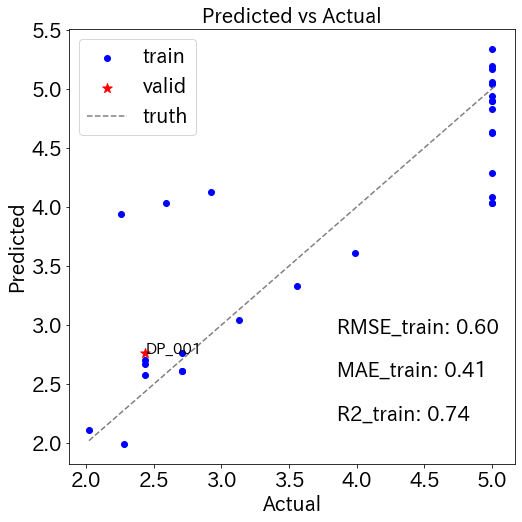

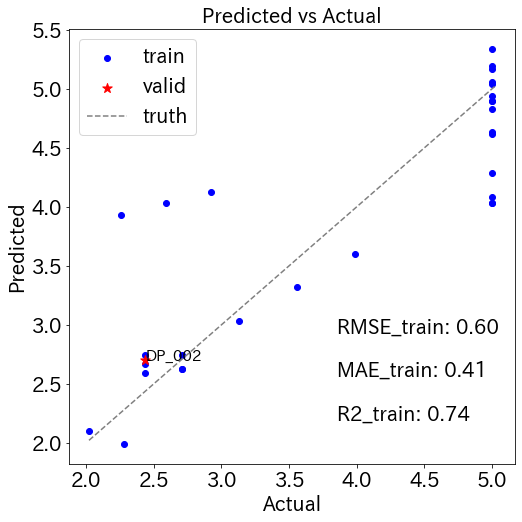

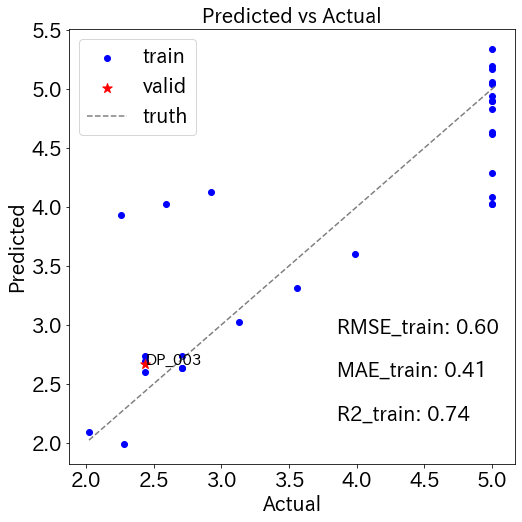

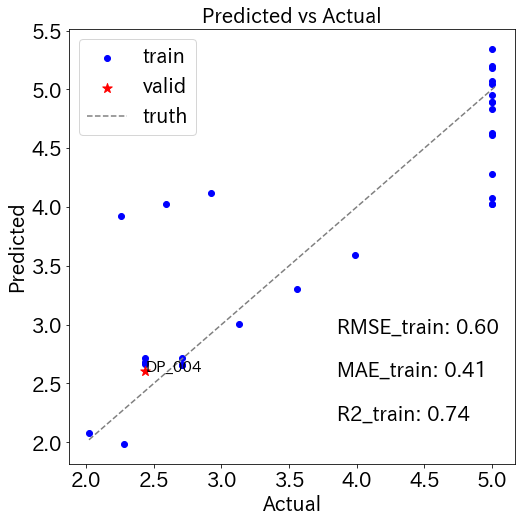

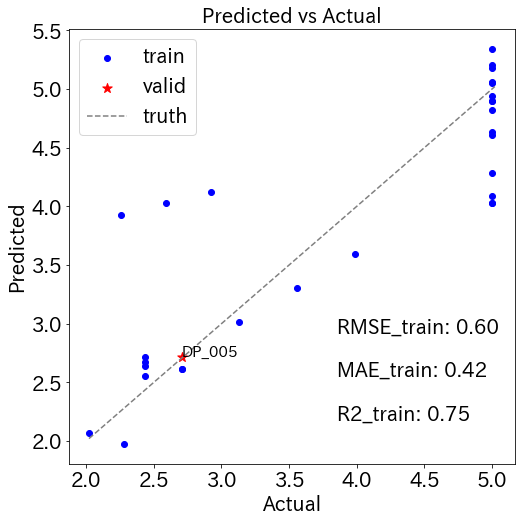

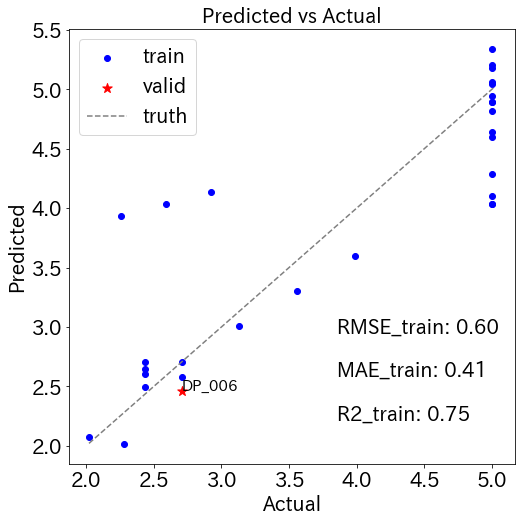

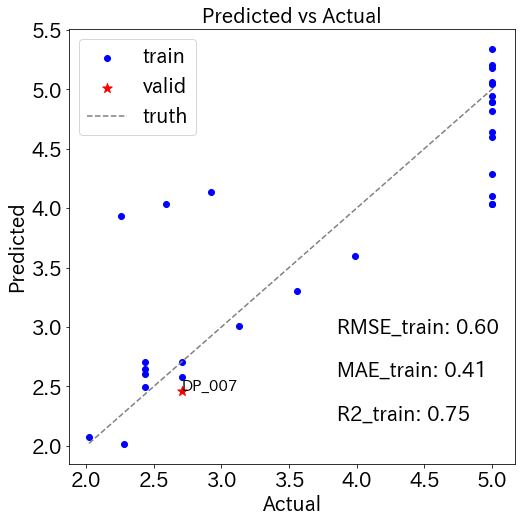

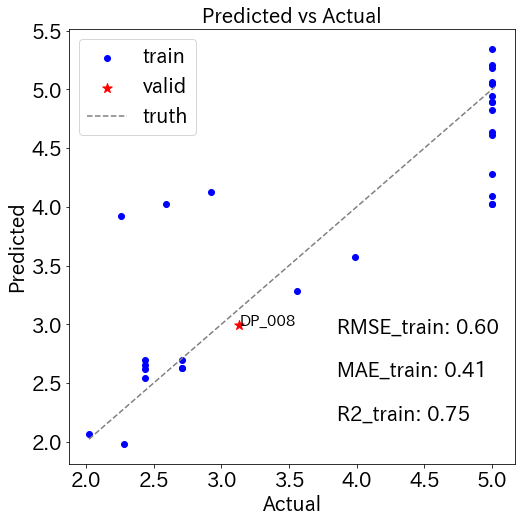

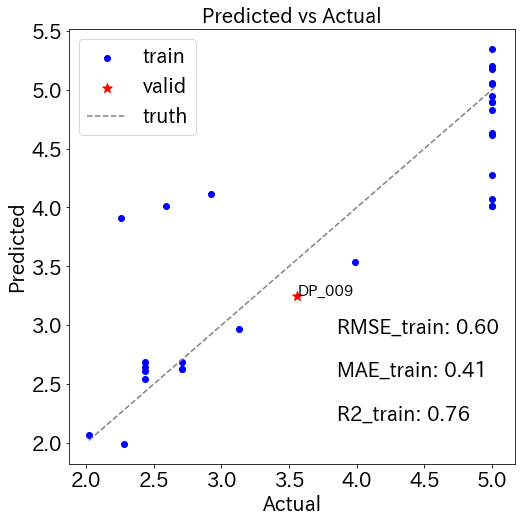

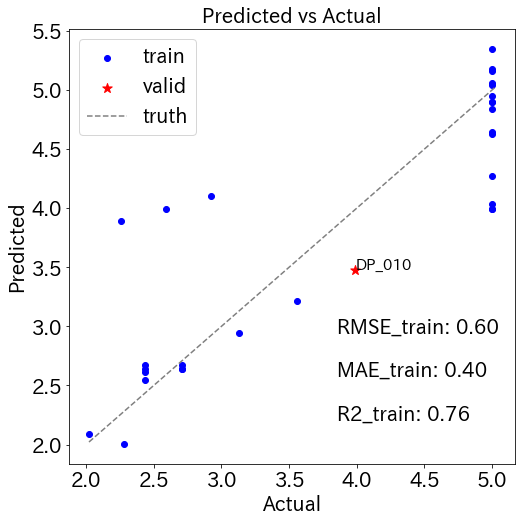

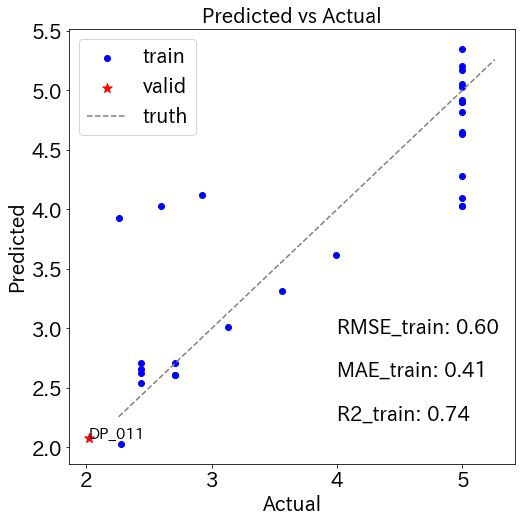

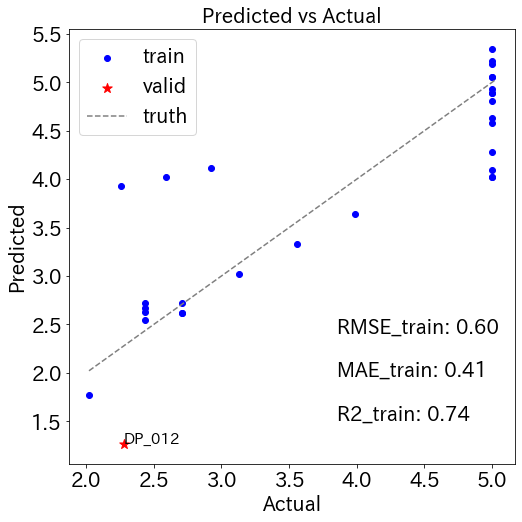

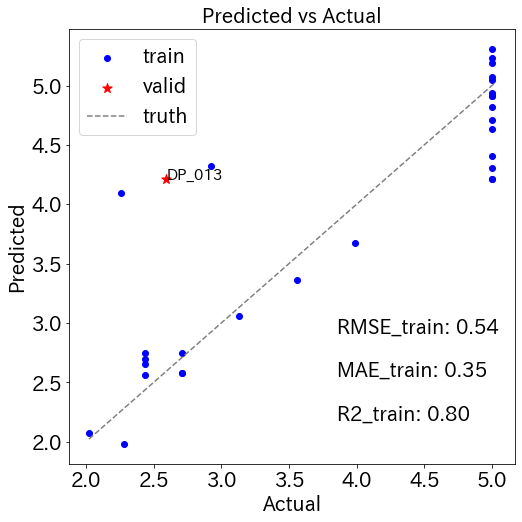

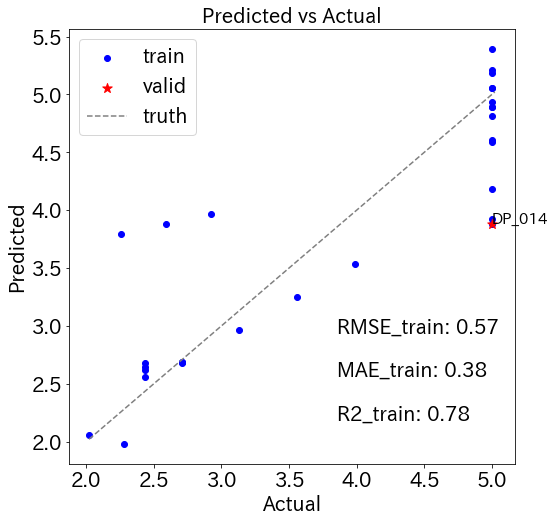

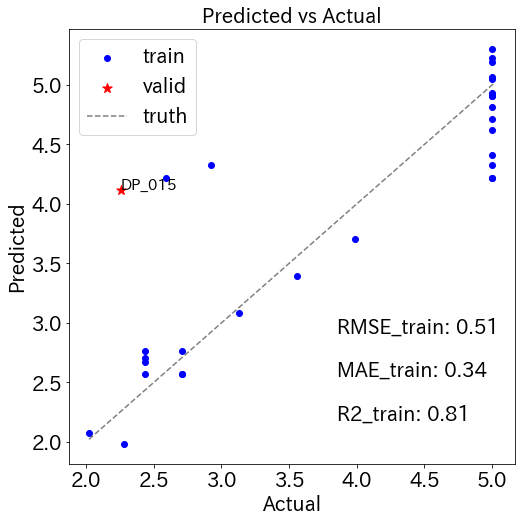

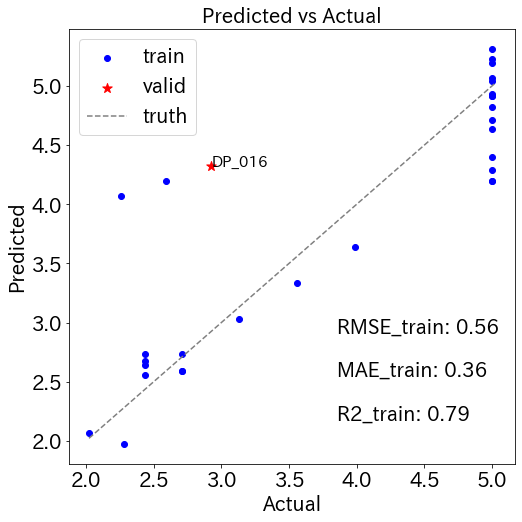

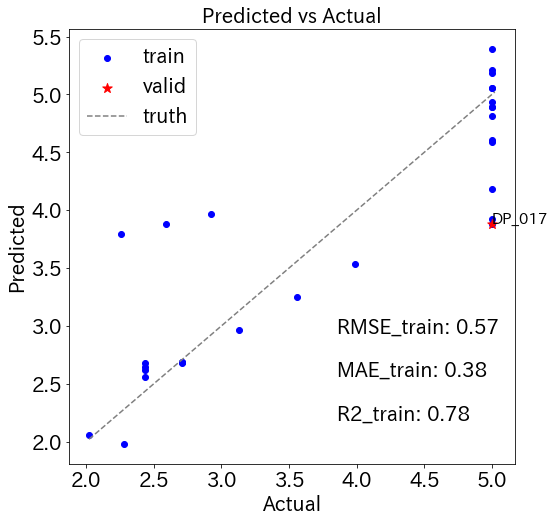

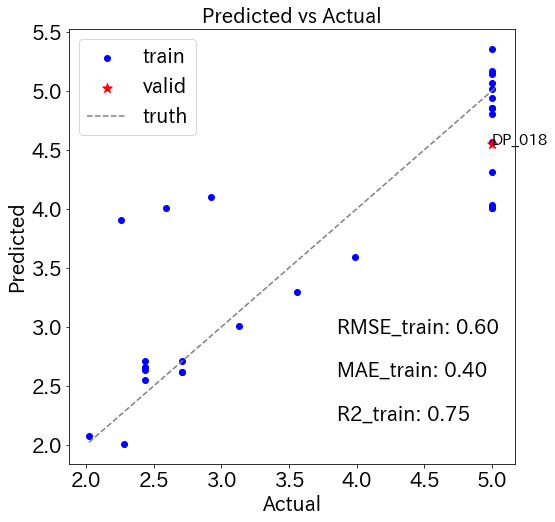

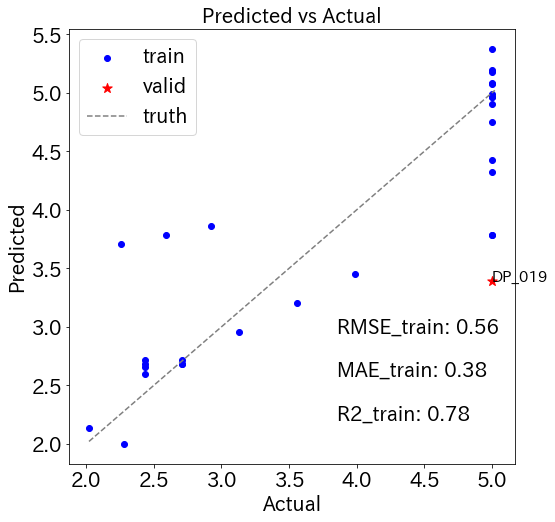

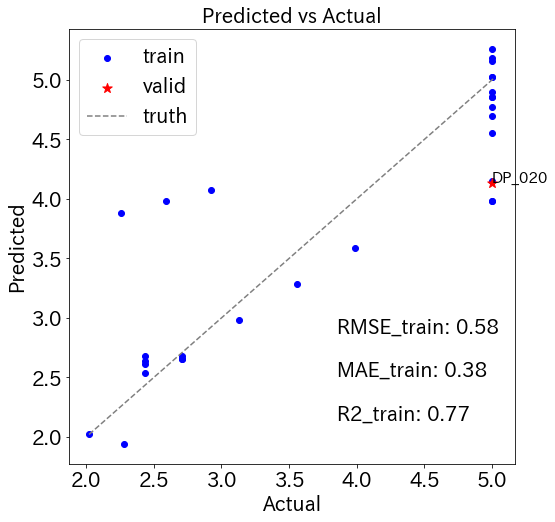

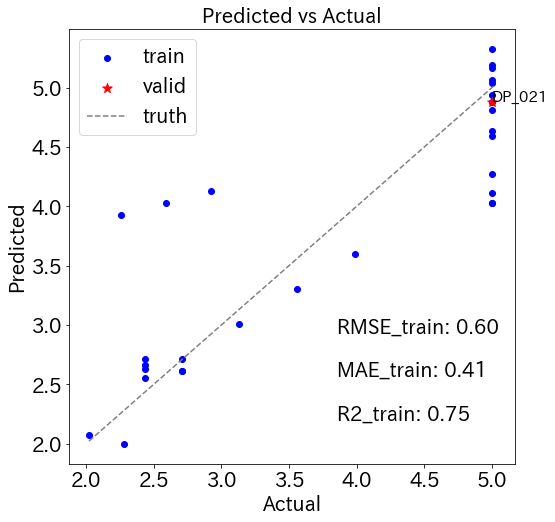

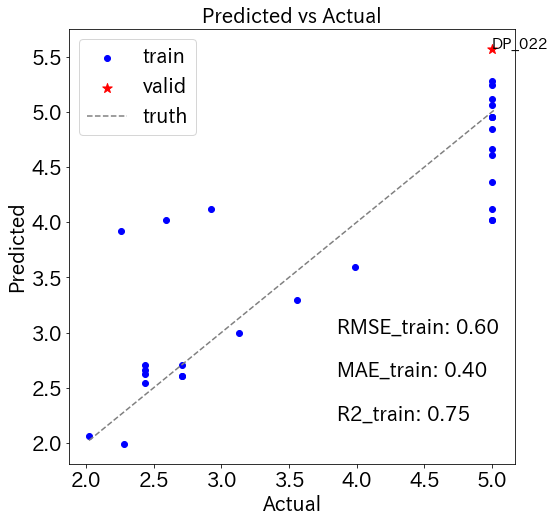

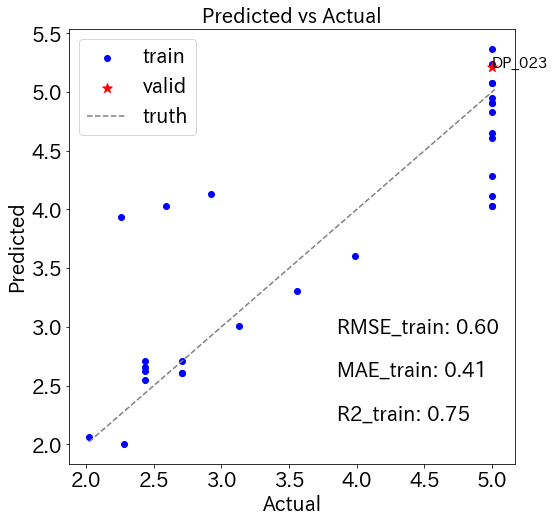

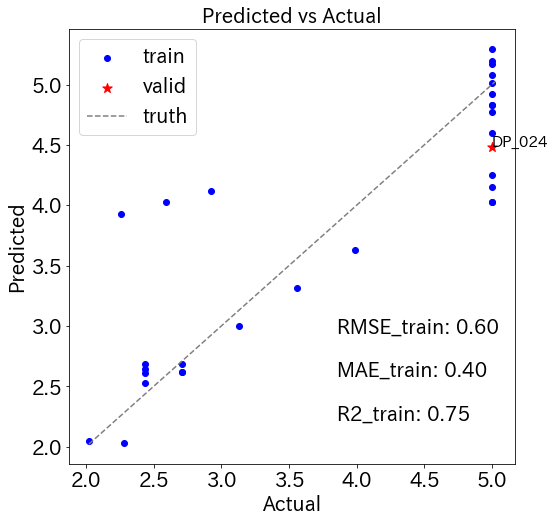

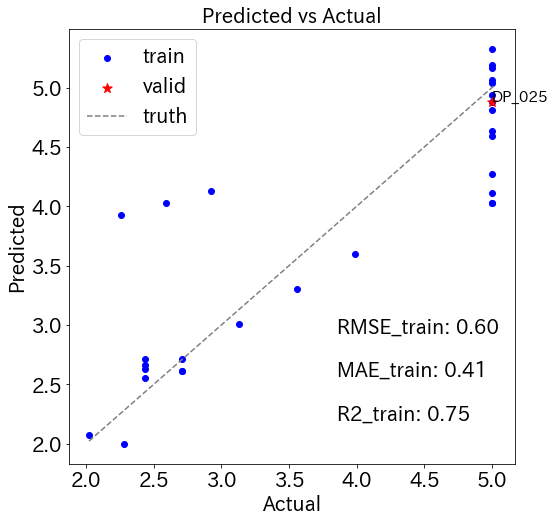

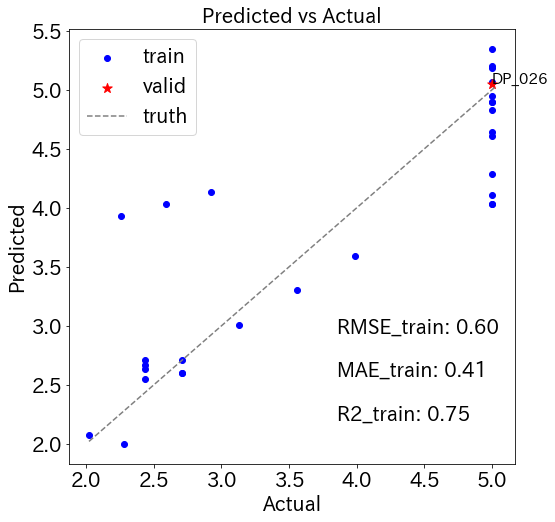

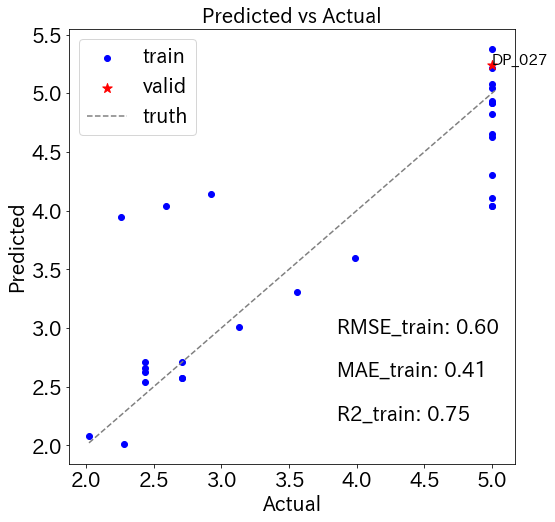

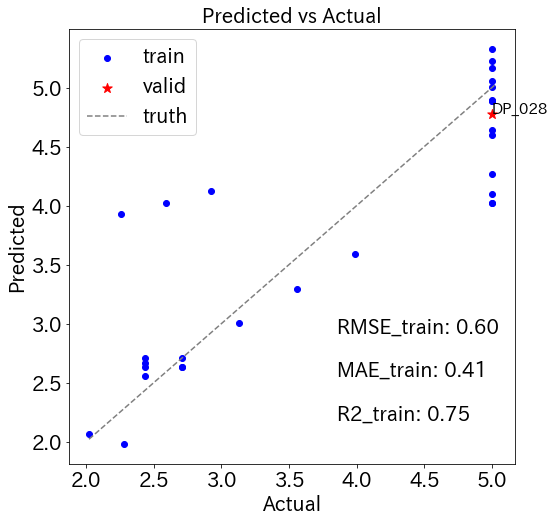

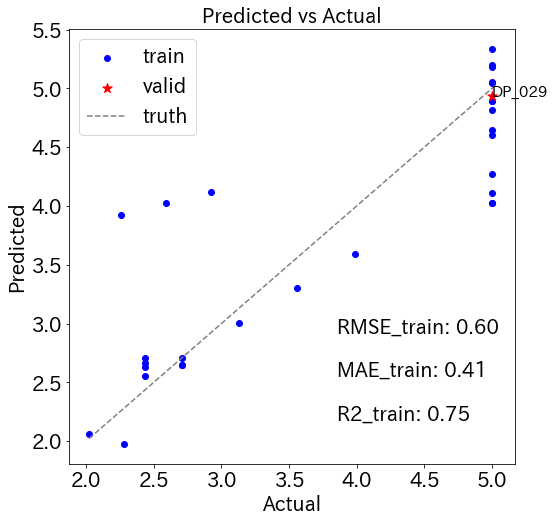

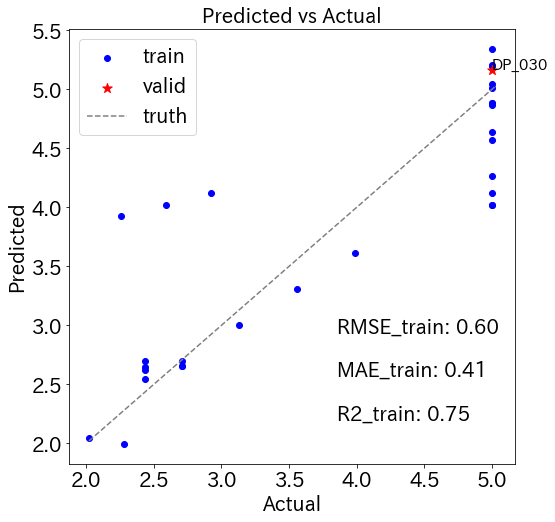

In [9]:
models = []
coef = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PLSRegression(n_components=2)

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    coef.append(model.coef_)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(y_train, y_pred_train, label="train", color="blue")
    plt.scatter(y_valid, y_pred_valid, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(y_train.min(), y_train.max() + 1)
    y_truth = x_truth
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(
        0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(train_df.iloc[valid_index]["サンプルID"]):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

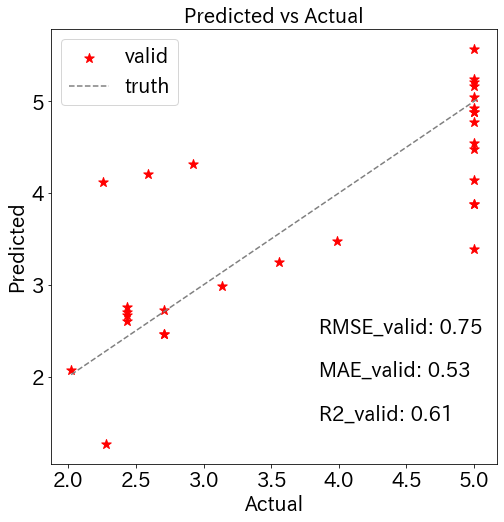

In [10]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title("Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
plt.legend()

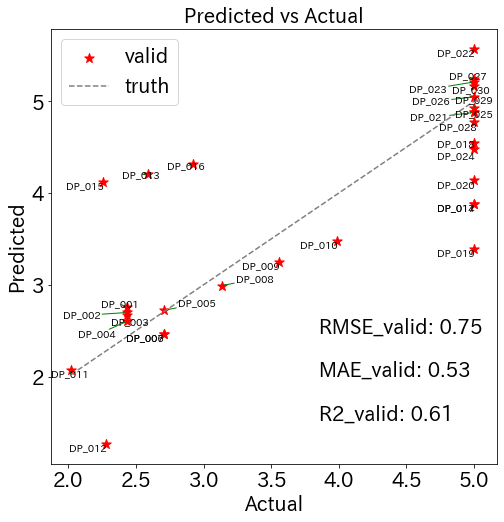

In [11]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title("Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(train_Y.values[i], oof[i], train_df["サンプルID"][i], fontsize=10)
    for i in range(len(train_Y))
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="green"))
plt.legend()

In [12]:
len(coef)

30

In [13]:
# 全てのモデルの係数の平均を算出
coef = np.array(coef)
coef = np.mean(coef, axis=0)
coef

array([[-0.12941752],
       [-0.12592702],
       [ 0.12299977],
       [-0.02879185],
       [ 0.10420624],
       [ 0.0375073 ],
       [ 0.01065124],
       [ 0.01065124],
       [ 0.02015571],
       [-0.00422141],
       [ 0.20317644],
       [-0.10298021],
       [ 0.        ],
       [ 0.        ],
       [ 0.14854324],
       [ 0.15459053],
       [ 0.        ],
       [ 0.        ]])

In [14]:
# coefをDataFrameに変換
coef_df = pd.DataFrame(coef, index=numeric_parameter_cols, columns=["coef"])
coef_df

,coef
溶媒１,-0.129418
溶媒2,-0.125927
溶媒3,0.123000
添加剤1,-0.028792
添加剤2,0.104206
界面活性剤１,0.037507
界面活性剤２,0.010651
界面活性剤３,0.010651
顔料１,0.020156
顔料２,-0.004221


In [15]:
# coef_dfをcoefの絶対値の降順にソート
coef_df = coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)
coef_df

,coef
定着樹脂１,0.203176
乾燥温度,0.154591
乾燥方式,0.148543
溶媒１,-0.129418
溶媒2,-0.125927
溶媒3,0.123000
添加剤2,0.104206
定着樹脂２,-0.102980
界面活性剤１,0.037507
添加剤1,-0.028792


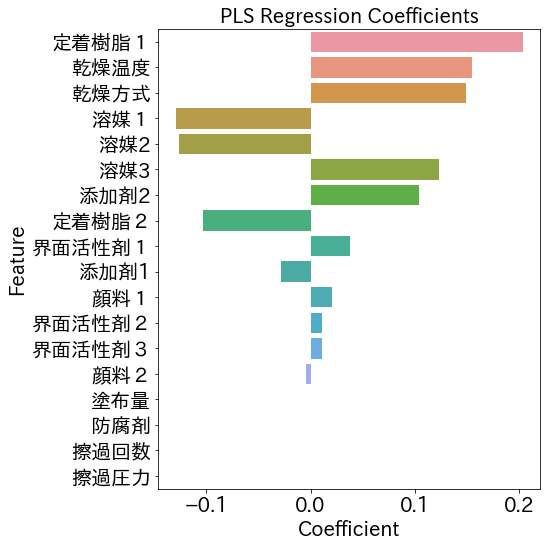

In [16]:
# coef_dfをsns.barplotで可視化
plt.figure(figsize=(8, 8))
sns.barplot(data=coef_df, x="coef", y=coef_df.index)
plt.title("PLS Regression Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()

In [17]:
test_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess_test.csv")
test_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_0XX,test,NaN,NaN,NaN,42.9,0,40,0,2,...,100,0.03,10,5,5,1.468048,8.02,38.46,9.82,正常


In [18]:
# 全てのmodelで予測してその平均をとる
test_X = test_df[numeric_parameter_cols]
preds = []
for model in models:
    pred = scaler_y.inverse_transform(
        model.predict(scaler_x.transform(test_X)).reshape(-1, 1)
    )
    preds.append(pred)
preds = np.array(preds)
preds = preds.mean(axis=0)
preds

array([[4.67263489]])